# HOPPS: hardware-aware optimal phase polynomial synthesis

**HOPPS** is a *hardware-aware optimal phase polynomial synthesis tool*. It computes optimal solutions using a SAT solver, supporting both CNOT count and CNOT depth minimization.

To run the tool, follow these steps:

1. **Define a logical circuit** composed of `{CNOT, R_z}` gates.  
2. **Mapping a circuit** (e.g., Qiskit) to a device.  
3. **Optimizing the Mapped Circuit** by using HOPPS to do hardware-aware resynthesis.

In the following, we provide examples on QAOA and general circuits to demonstrate how to use HOPPS.

### Synthesis small QAOA circuit
#### Read a logical QAOA circuit

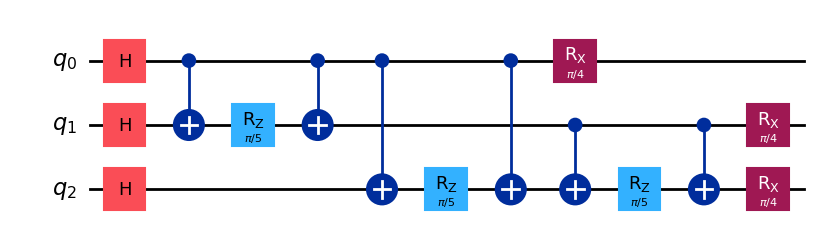

In [8]:
from src.util import read_circuit_qiskit

# Number of qubit
n_qubit = 3

# Number of terms (like 'IZZI')
k = 3

# Logical Quantum Circuit
file = "benchmark/MaxCut_Random/logical/"+"Random"+ str(n_qubit) +"_"+ str(k) +"_logical_circuit.qpy"

qc, name = read_circuit_qiskit(file)

qc.draw()


#### Strip circuit into `{CNOT, R_z}` circuit

In [ ]:
from qiskit import QuantumCircuit
from src.util import strip_qaoa_circuit
    
qc = strip_qaoa_circuit(qc)
qc.draw()

#### Extract phase polynomial representation from circuit

In [10]:
from src.util import extract_parity_from_circuit_custom

output_parity, term_parity, params = extract_parity_from_circuit_custom(qc)

#### Mapping the circuit using qiskit

In [ ]:
import json
from qiskit import transpile
from qiskit.transpiler import CouplingMap

def qiskit_initial_layout(qc, backend):
    if backend == "melbourne":
        with open("Coupling_maps/melbourne.json", "r") as f:
            coupling_map = json.load(f)
    
    coupling = CouplingMap(couplinglist=coupling_map)
    transpiled_qc = transpile(
        qc,
        coupling_map=coupling,
        optimization_level=3
    )

    physical_layout = []
    for i, (qubit, index) in enumerate(transpiled_qc.layout.initial_layout.get_virtual_bits().items()):
        if index!=0:
            physical_layout.append(index)
        else:
            break

    sub_coupling_maps = []
    for edge in coupling:
        if edge[0] in physical_layout and edge[1] in physical_layout:
            sub_coupling_maps.append((physical_layout.index(edge[0]),physical_layout.index(edge[1])))
    return sub_coupling_maps

sub_coupling_maps = qiskit_initial_layout(qc, "melbourne")
        

#### Using HOPPS to get optimal solution

In [12]:
from src import z3_sat_solve_free_output

input_parity = [[True if i == j else False for j in range(n_qubit)] for i in range(n_qubit)]

# Systhesis the circuit
systhesis_circuit,_ = z3_sat_solve_free_output(n_qubit, 
                                                sub_coupling_maps, 
                                                term_parity, 
                                                input_parity, 
                                                output_parity, 
                                                params,
                                                cnot_or_depth='cnot', 
                                                max_k =  20,
                                                display = True)

Elapsed time: 0.003157 seconds
No solution found for 1
Elapsed time: 0.009628 seconds
No solution found for 2
Elapsed time: 0.002369 seconds
No solution found for 3
Elapsed time: 0.002941 seconds
No solution found for 4
Elapsed time: 0.003862 seconds
No solution found for 5
Elapsed time: 0.010305 seconds
solution found for 6current depth: 6
Try 6 depth, success
Try 5 depth, fail


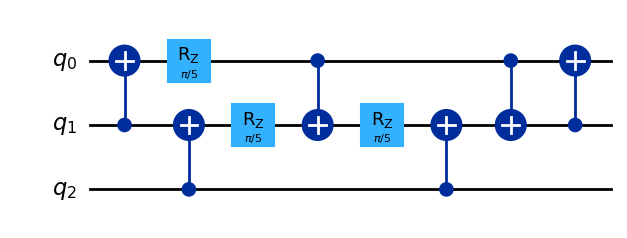

In [13]:
systhesis_circuit.draw()

### For general circuits
We skip the mapping process, direct read mapped result from benchmark https://github.com/irfansha/Q-Synth/tree/main/Benchmarks/ECAI-24/permuted_mapped. 
#### Optimizing the circuit

In [ ]:
from src.paritioners import general_paritioner
from 

def block_opt_general_parallel(qc,coupling_map,cnot_or_depth = 'cnot',max_depth = 0,block_size=10, max_k=25, method = 'phasepoly', display = False):
    final_qc =  general_paritioner(qc, method)
    for id, node in enumerate(final_qc.data):

        if node.operation.name == 'barrier' or node.operation.name == 'measure':
            opt_qc.append(node)

        elif len(node.operation.definition.data) > 1 and len(node.qubits)>1:
            decomposed_block = node.operation.definition
            # print("num_qubits", decomposed_block.num_qubits)
            # print("Cnot", decomposed_block.count_ops())
                
            parity_matrix, terms, params =  extract_parity_from_circuit_custom(decomposed_block)
            input_parity = [[True if i == j else False for j in range(decomposed_block.num_qubits)] for i in range(decomposed_block.num_qubits)]

            list_gate_qubits = [final_qc.qubits.index(q) for q in node.qubits]
            logical_subsubcoupling_map = coupling_map_physical_index_to_logical_index(get_subcoupling_map(coupling_map, list_gate_qubits), list_gate_qubits)
            
            # print(decomposed_block.num_qubits, 
            #                                                           logical_subsubcoupling_map, 
            #                                                           terms, 
            #                                                           input_parity, 
            #                                                           parity_matrix, 
            #                                                           params)
            
            if decomposed_block.num_qubits <=1:
                block_qcs.append(optimized_block)
                block_data_id.append(id)
                opt_qc = opt_qc.compose(decomposed_block, list_gate_qubits)
            elif decomposed_block.num_qubits > block_size:
    return final_qc



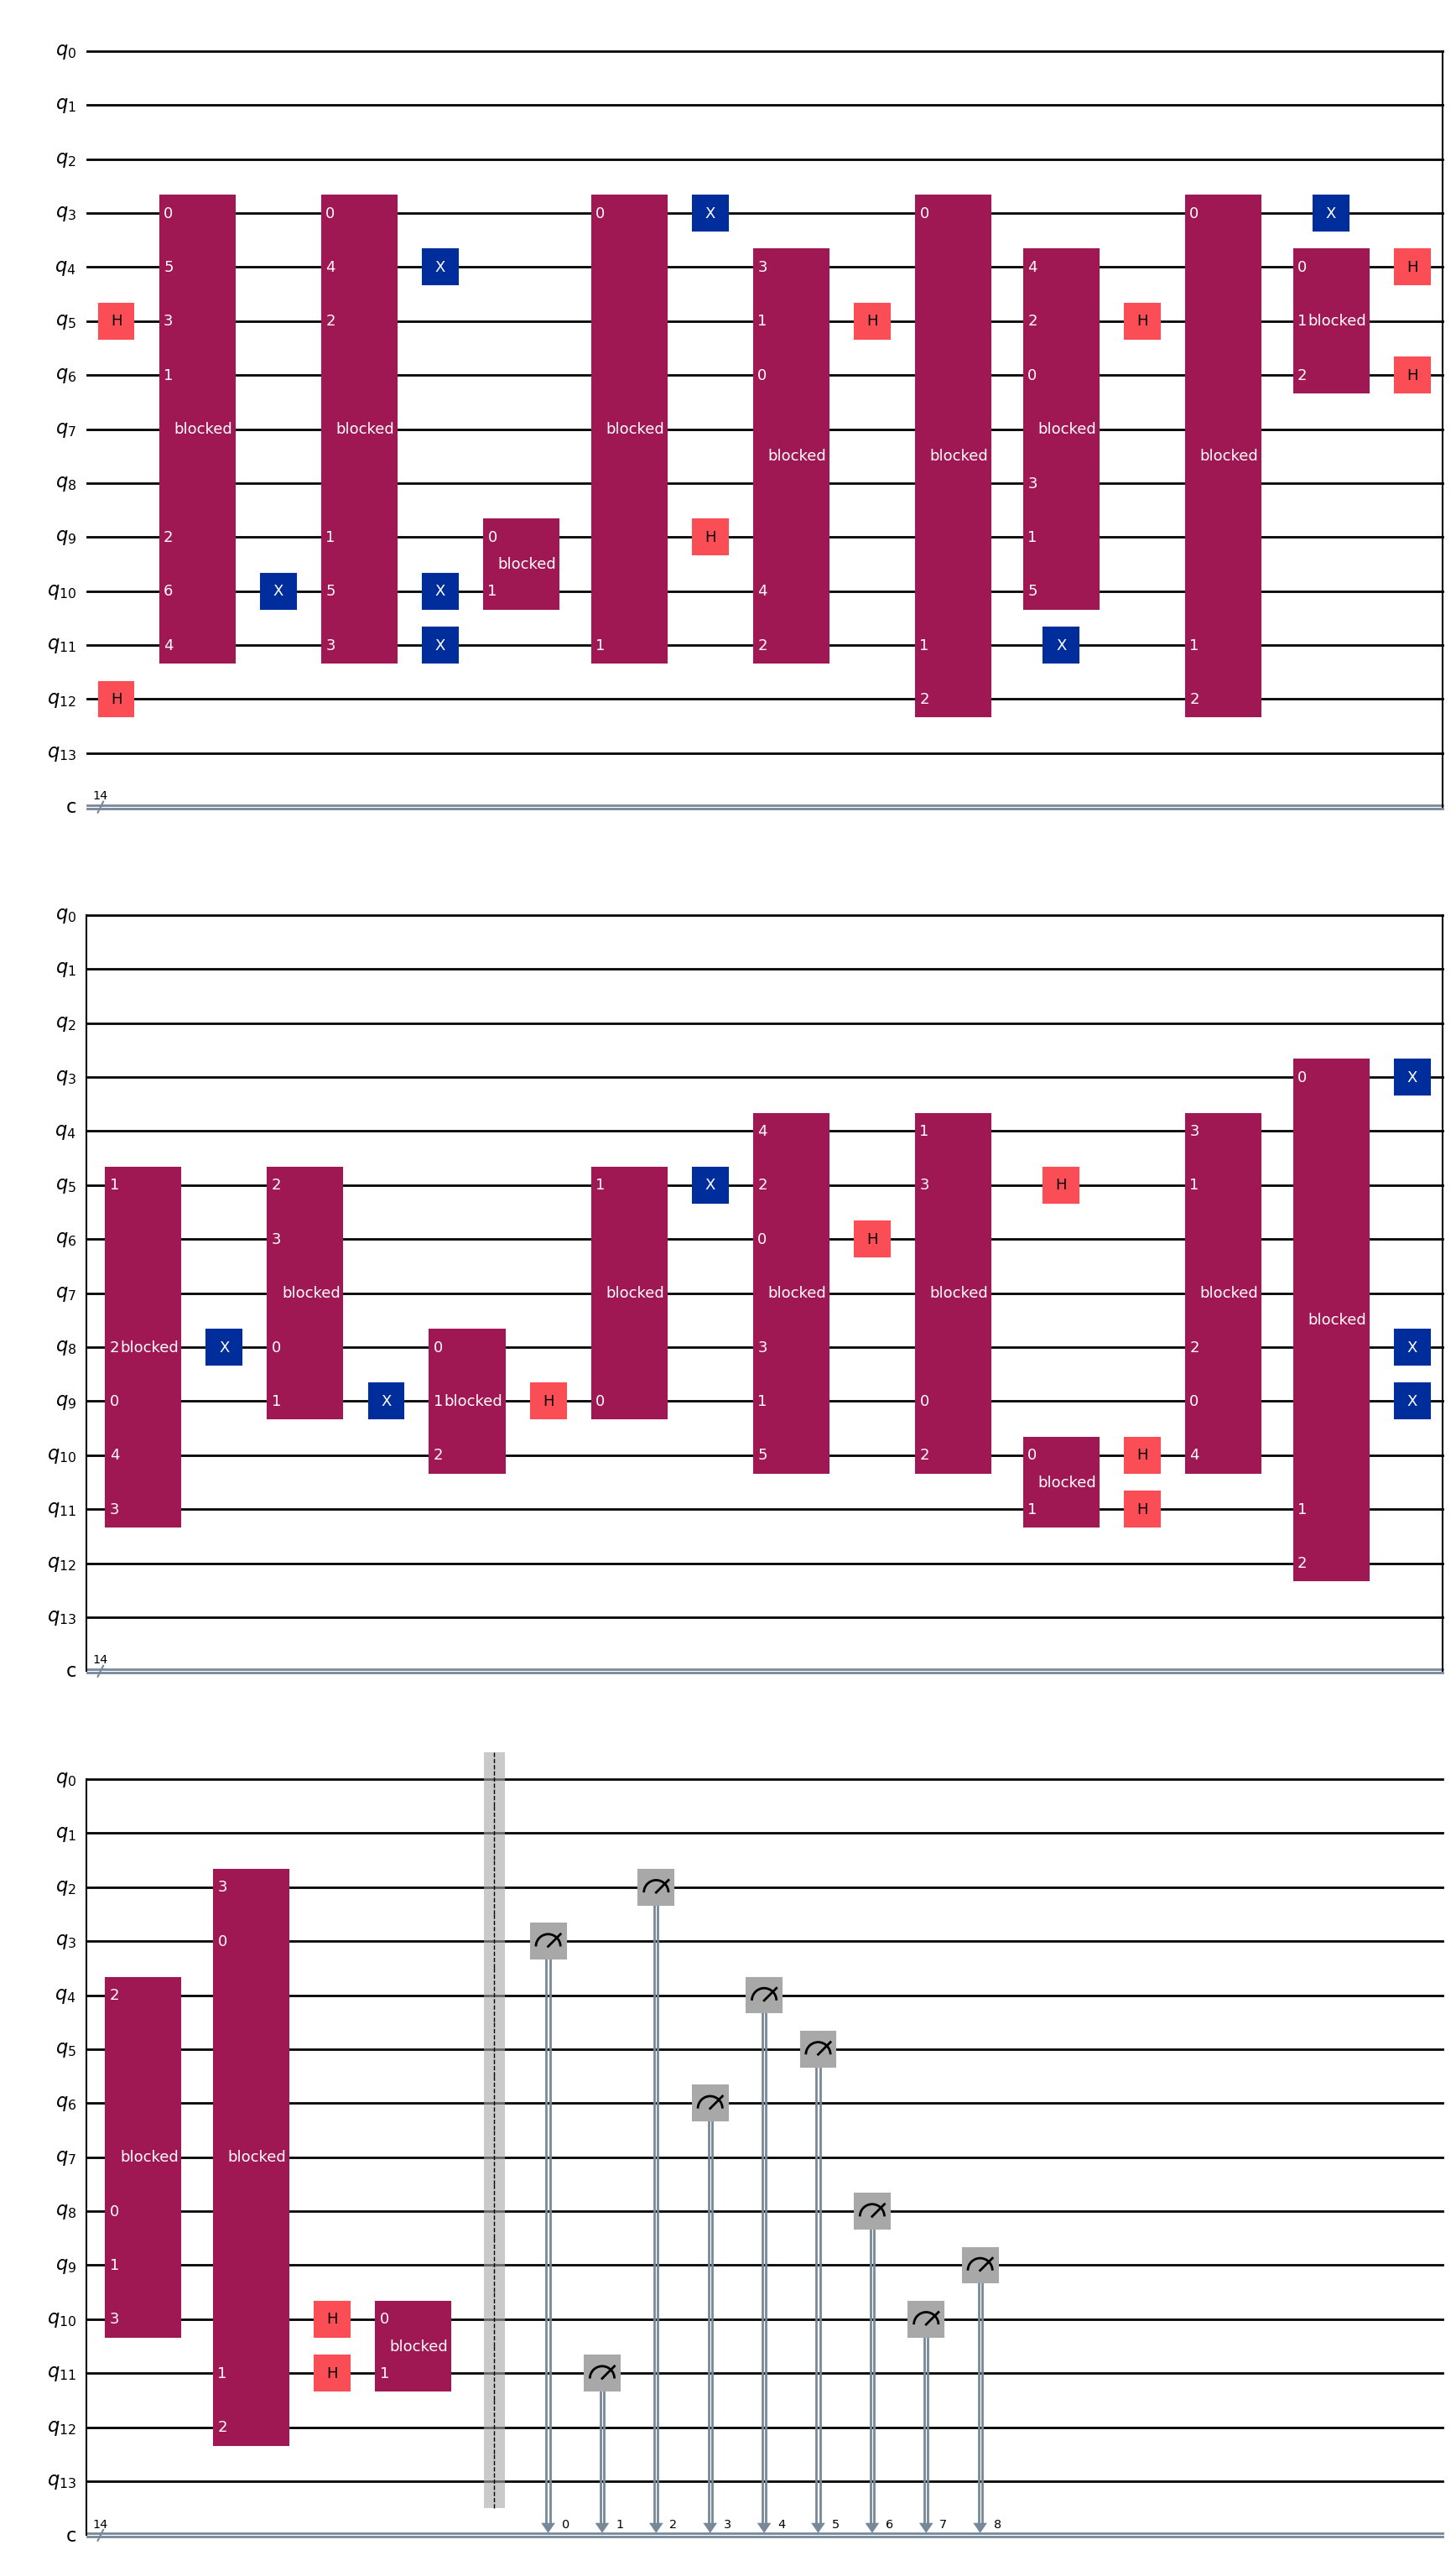

In [13]:
import os
import json
from qiskit import QuantumCircuit

# Get hardware constrains (Note: is should be same size as circuit; allow to have ancilla qubit in the circuit)
with open("Coupling_maps/melbourne.json", "r") as f:
    coupling_map = json.load(f)

# Get a mapped circuit
path = 'benchmark/permuted_mapped/mod_mult_55.qasm'
qc = QuantumCircuit.from_qasm_file(path)

opt_qc = block_opt_general_parallel(qc, 
                           coupling_map, 
                           cnot_or_depth='cnot', # two options: cnot optimal or depth optimal
                           block_size=8, # max number of qubit for each block
                           max_depth=15, # max depth allow for each block
                           method = 'phasepoly',
                           display = True) # 'phasepoly' or 'cnot'

opt_qc.draw()

In [ ]:

def block_opt_general(qc,coupling_map,cnot_or_depth = 'cnot',max_depth = 0,block_size=10, max_k=25, method = 'phasepoly', display = False):
    final_qc =  general_paritioner(qc, method)
    opt_qc =  QuantumCircuit(final_qc.qubits, final_qc.clbits)
    block_qcs = []
    block_data_id = []

    for id, node in enumerate(final_qc.data):

        if node.operation.name == 'barrier' or node.operation.name == 'measure':
            opt_qc.append(node)

        elif len(node.operation.definition.data) > 1 and len(node.qubits)>1:
            decomposed_block = node.operation.definition
            # print("num_qubits", decomposed_block.num_qubits)
            # print("Cnot", decomposed_block.count_ops())
                
            parity_matrix, terms, params =  extract_parity_from_circuit_custom(decomposed_block)
            input_parity = [[True if i == j else False for j in range(decomposed_block.num_qubits)] for i in range(decomposed_block.num_qubits)]

            list_gate_qubits = [final_qc.qubits.index(q) for q in node.qubits]
            logical_subsubcoupling_map = coupling_map_physical_index_to_logical_index(get_subcoupling_map(coupling_map, list_gate_qubits), list_gate_qubits)
            
            # print(decomposed_block.num_qubits, 
            #                                                           logical_subsubcoupling_map, 
            #                                                           terms, 
            #                                                           input_parity, 
            #                                                           parity_matrix, 
            #                                                           params)
            
            if decomposed_block.num_qubits <=1:
                block_qcs.append(optimized_block)
                block_data_id.append(id)
                opt_qc = opt_qc.compose(decomposed_block, list_gate_qubits)
            elif decomposed_block.num_qubits > block_size:
                optimized_block = block_opt_qaoa(decomposed_block, 
                                            logical_subsubcoupling_map,
                                            block_size = block_size,
                                            max_depth = max_depth,
                                            max_k  = max_k,
                                            cnot_or_depth='cnot',
                                            display = display)
                block_qcs.append(optimized_block)
                block_data_id.append(id)
                opt_qc = opt_qc.compose(optimized_block, list_gate_qubits)
            else:
                optimized_block,_ = z3_sat_solve_free_output(decomposed_block.num_qubits, 
                                                                        logical_subsubcoupling_map, 
                                                                        terms, 
                                                                        input_parity, 
                                                                        parity_matrix, 
                                                                        params,
                                                                        cnot_or_depth=cnot_or_depth, 
                                                                        max_k =  max_k,
                                                                        display = display)
                block_qcs.append(optimized_block)
                block_data_id.append(id)
                opt_qc = opt_qc.compose(optimized_block, list_gate_qubits)
        
        else:
            list_gate_qubits = [final_qc.qubits.index(q) for q in node.qubits]
            opt_qc = opt_qc.compose(node.operation.definition, list_gate_qubits)

    return opt_qc

In [1]:
import os
import json
from qiskit import QuantumCircuit

# Get hardware constrains (Note: is should be same size as circuit; allow to have ancilla qubit in the circuit)
with open("Coupling_maps/melbourne.json", "r") as f:
    coupling_map = json.load(f)

# Get a mapped circuit
path = 'benchmark/permuted_mapped/mod_mult_55.qasm'
qc = QuantumCircuit.from_qasm_file(path)

# Use sat optimization
from src import block_opt_general, block_opt_qaoa, free_block_opt
opt_qc = block_opt_general(qc, 
                           coupling_map, 
                           cnot_or_depth='cnot', # two options: cnot optimal or depth optimal
                           block_size=8, # max number of qubit for each block
                           max_depth=15, # max depth allow for each block
                           method = 'phasepoly',
                           display = True) # 'phasepoly' or 'cnot'

Elapsed time: 0.000788 seconds
No solution found for 1
Elapsed time: 0.005595 seconds
No solution found for 2
Elapsed time: 0.008503 seconds
No solution found for 3
Elapsed time: 0.012590 seconds
No solution found for 4
Elapsed time: 0.022276 seconds
No solution found for 5
Elapsed time: 0.037593 seconds
No solution found for 6
Elapsed time: 0.039030 seconds
solution found for 7current depth: 7
Try 6 depth, success
Try 5 depth, success
Try 4 depth, fail
Elapsed time: 0.000565 seconds
No solution found for 1
Elapsed time: 0.004795 seconds
No solution found for 2
Elapsed time: 0.007224 seconds
No solution found for 3
Elapsed time: 0.010369 seconds
No solution found for 4
Elapsed time: 0.014315 seconds
No solution found for 5
Elapsed time: 0.030961 seconds
No solution found for 6
Elapsed time: 0.049320 seconds
No solution found for 7
Elapsed time: 0.133167 seconds
No solution found for 8
Elapsed time: 0.035836 seconds
solution found for 9current depth: 9
Try 8 depth, success
Try 7 depth, 

#### Checking Performance

In [3]:
from qiskit import transpile
basis_gates = ['id', 'rz', 'cx', 'reset','h','rx']
transpiled_qc = transpile(qc, 
                        basis_gates = basis_gates, 
                        coupling_map = coupling_map, 
                        initial_layout = [i for i in range(qc.num_qubits)],
                        optimization_level=3)

transpiled_opt_qc = transpile(opt_qc, 
                        basis_gates = basis_gates, 
                        coupling_map = coupling_map, 
                        initial_layout = [i for i in range(qc.num_qubits)],
                        optimization_level=3)

from src.util import strip_circuit, remove_gates, swap_to_cnot, get_layout_from_circuit

print('Count/Depth')

print(qc.count_ops()['cx'] + 3*qc.count_ops()['swap'], strip_circuit(qc).depth(), '-> Orginial Mapped Quantum Circuit')

print(transpiled_qc.count_ops()['cx'], strip_circuit(transpiled_qc).depth(), '-> Orginial Mapped Quantum Circuit + qiskit L3')

print(opt_qc.count_ops()['cx'], strip_circuit(opt_qc).depth(), '-> Orginial Mapped Quantum Circuit + HOPPS-Cnot')

print(transpiled_opt_qc.count_ops()['cx'], strip_circuit(transpiled_opt_qc).depth(), '-> Orginial Mapped Quantum Circuit + HOPPS-Cnot + qiskit L3')

Count/Depth
131 79 -> Orginial Mapped Quantum Circuit
147 101 -> Orginial Mapped Quantum Circuit + qiskit L3
106 61 -> Orginial Mapped Quantum Circuit + HOPPS-Cnot
100 60 -> Orginial Mapped Quantum Circuit + HOPPS-Cnot + qiskit L3


#### Circuits Verify (Optional)

To verify circuit equivalence, we insert two random circuits—one before and one after—around both the original and the optimized circuits. Two circuits are considered equivalent if, for any input state, they produce the same output under any measurement basis. We use qiskit_aer to simulate the output probability distributions and compute the fidelity between the two circuits. You can run the verification multiple times to observe the fidelity across different randomizations.

In [4]:
from util import evaluate_circuit, calculate_fidelity
from qiskit.circuit.random import random_circuit

random_qc1 = random_circuit(qc.num_qubits, 20)

random_qc2 = random_circuit(qc.num_qubits, 20)

qc1 = QuantumCircuit(qc.num_qubits)
qc1 = random_qc1.compose(qc)
qc1 = qc1.compose(random_qc2)

qc2 = QuantumCircuit(qc.num_qubits)
qc2 = random_qc1.compose(opt_qc)
qc2 = qc2.compose(random_qc2)

prob1 = evaluate_circuit(qc1, 2**20)

prob2 = evaluate_circuit(qc2, 2**20)

calculate_fidelity(prob1, prob2)


np.float64(0.9997573343634277)

# HOPPS Iterative Blockwise Optimization

#### Read a QAOA circuit

In [4]:
from src import z3_sat_solve_free_output
from qiskit import QuantumCircuit
from src.util import read_circuit_qiskit

# Number of qubit
n_qubit = 16

# Number of terms (like 'IZZI')
k = 4

# Logical Quantum Circuit
file = "benchmark/MaxCut_Regular/logical/"+"Regular"+ str(n_qubit) +"_"+ str(k) +"_logical_circuit.qpy"
qc, name = read_circuit_qiskit(file)

#### Mapping the circuit using qiskit

In [5]:
import json
from qiskit import transpile
from qiskit.transpiler import CouplingMap

def qiskit_initial_layout(qc, backend):
    if backend == "melbourne":
        with open("Coupling_maps/melbourne.json", "r") as f:
            coupling_map = json.load(f)
    elif backend == "kyiv":
        with open("Coupling_maps/kyiv.json", "r") as f:
            coupling_map = json.load(f)
    
    coupling = CouplingMap(couplinglist=coupling_map)
    transpiled_qc = transpile(
        qc,
        coupling_map=coupling,
        optimization_level=3
    )

    physical_layout = []
    for i, (qubit, index) in enumerate(transpiled_qc.layout.initial_layout.get_virtual_bits().items()):
        if index!=0:
            physical_layout.append(index)
        else:
            break

    sub_coupling_maps = []
    for edge in coupling:
        if edge[0] in physical_layout and edge[1] in physical_layout:
            sub_coupling_maps.append((physical_layout.index(edge[0]),physical_layout.index(edge[1])))
    return sub_coupling_maps

sub_coupling_maps = qiskit_initial_layout(qc, "kyiv")

In [6]:
def two_direct_coupling_map(coupling_map):
    td_coupling_map = []
    for edge in coupling_map:
        if edge not in td_coupling_map:
            td_coupling_map.append(edge)
        if edge[::-1] not in td_coupling_map:
            td_coupling_map.append(edge[::-1])
    return td_coupling_map

def qiskit_mapped_circuit(qc, coupling_map):
    td_coupling_map = two_direct_coupling_map(coupling_map)
    coupling = CouplingMap(couplinglist=td_coupling_map)
    basis_gates = ['id', 'rz', 'cx', 'reset','h','swap', 'rx']
    transpiled_qc = transpile(
        qc,
        basis_gates = basis_gates,
        routing_method="sabre",
        coupling_map=coupling,
        optimization_level=1,
    )
    return transpiled_qc

transpiled_qc = qiskit_mapped_circuit(qc, sub_coupling_maps)
# transpiled_qc.draw()


#### Iteratively blockwise optimize the circuit

In [7]:
from src.blockwise_opt import block_opt_qaoa
from src.util import strip_circuit, strip_qaoa_circuit
max_run = 10
cnot_or_depth = 'depth'

import time
td_coupling_map = two_direct_coupling_map(sub_coupling_maps)
opt_qc = strip_qaoa_circuit(transpiled_qc)
last_run_cnot = opt_qc.count_ops()['cx']
last_run_depth = strip_circuit(opt_qc).depth()
for i in range(int(max_run/2)):
    start_time = time.time()
    opt_qc = block_opt_qaoa(opt_qc, coupling_map=td_coupling_map,cnot_or_depth=cnot_or_depth, max_depth=20, block_size =5, display=False)
    if cnot_or_depth == 'cnot' and last_run_cnot == opt_qc.count_ops()['cx']:
            break
    elif cnot_or_depth == 'depth' and last_run_depth == strip_circuit(opt_qc).depth():
            break
    end_time = time.time() 
    print('iteration_time:', i,'time',end_time - start_time)    
    print('iteration_time:', i, opt_qc.count_ops()['cx'], strip_circuit(opt_qc).depth())
    last_run_cnot = opt_qc.count_ops()['cx']
    last_run_depth = strip_circuit(opt_qc).depth()

for i in range(max_run - int(max_run/2)):
    start_time = time.time()
    opt_qc = block_opt_qaoa(opt_qc, coupling_map=td_coupling_map,cnot_or_depth=cnot_or_depth, block_size=4, method='Cluster', display=False)
    end_time = time.time() 
    print('iteration_time:', i,'time',end_time - start_time)   
    print('Cluster_iteration_time:', i, opt_qc.count_ops()['cx'], strip_circuit(opt_qc).depth())

print('final Cnot: ', opt_qc.count_ops()['cx'])
print('final Depth: ', strip_circuit(opt_qc).depth())

iteration_time: 0 time 6.885035991668701
iteration_time: 0 144 76
iteration_time: 1 time 6.94982385635376
iteration_time: 1 132 69
iteration_time: 2 time 7.284778356552124
iteration_time: 2 130 67
iteration_time: 0 time 3.9940919876098633
Cluster_iteration_time: 0 126 67
iteration_time: 1 time 3.993217706680298
Cluster_iteration_time: 1 124 67
iteration_time: 2 time 4.152428865432739
Cluster_iteration_time: 2 124 67
iteration_time: 3 time 4.04545783996582
Cluster_iteration_time: 3 123 66
iteration_time: 4 time 3.717444896697998
Cluster_iteration_time: 4 123 66
final Cnot:  123
final Depth:  66


#### Verify the optimized circuit

In [8]:
import numpy as np
def recover_qaoa_circuit(qc, rx_params):
    new_qc = QuantumCircuit(qc.num_qubits)
    for i in range(qc.num_qubits):
        new_qc.h(i)
    new_qc = new_qc.compose(qc)
    for i in range(qc.num_qubits):
        new_qc.rx(rx_params, i)
    return new_qc

optimized_qc = recover_qaoa_circuit(opt_qc , np.pi/4)

In [9]:
from util import evaluate_circuit, calculate_fidelity
from qiskit.circuit.random import random_circuit

prob1 = evaluate_circuit(optimized_qc, 2**23)

prob2 = evaluate_circuit(transpiled_qc, 2**23)

calculate_fidelity(prob1, prob2)

np.float64(0.9956389734775608)

In [3]:
!pip list

Package             Version
------------------- -----------
appnope             0.1.4
asttokens           3.0.0
bqskit              1.2.0
bqskitrs            0.4.1
comm                0.2.2
contourpy           1.3.0
cycler              0.12.1
debugpy             1.8.14
decorator           5.2.1
dill                0.4.0
exceptiongroup      1.2.2
executing           2.2.0
fonttools           4.57.0
importlib_metadata  8.6.1
importlib_resources 6.5.2
ipykernel           6.29.5
ipython             8.18.1
jedi                0.19.2
jupyter_client      8.6.3
jupyter_core        5.7.2
kiwisolver          1.4.7
lark                1.2.2
matplotlib          3.9.4
matplotlib-inline   0.1.7
mpmath              1.3.0
nest-asyncio        1.6.0
networkx            3.2.1
numpy               2.0.2
packaging           25.0
pandas              2.2.3
parso               0.8.4
pbr                 6.1.1
pexpect             4.9.0
pillow              11.2.1
pip                 25.1
platformdirs        4.3.7